## Subsampling analysis

subsample the number of inidvidualas/RNA-seq datasets and look at how number of signals changes

In [1]:
import pandas as pd
import numpy as np
import os
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import ast

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

# load R for some R cells
%load_ext rpy2.ipython


prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

I then run snakemake on each sumsample made with 'make_subsamples.ipynb' to get QTLs with config files in config/subsampling/


this next analysis assumes results in those folders

In [2]:
subsample_output_folder = f'{prefix}/config/subsampling'

### configs across subsamples

In [6]:
# load in the configs for each 

subsample_nums = [100,200,300]

sub_configs = {}
for num_samples in subsample_nums:
    config_path= f'{subsample_output_folder}/{num_samples}_subsample.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        sub_configs[num_samples] = config

main_config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(main_config_path, 'r') as f:
    final_output_config = yaml.safe_load(f)


tissue_ids = load_tissue_ids(final_output_config)
tissue_df = load_tissue_df(final_output_config)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


my_tissue_id = tissue_ids[3]

## number of singals of each group across sample sizes

In [7]:
sample_sizes = pd.read_csv(final_output_config['gtex_meta'], sep='\t')

In [24]:
sub_signals = {}
for i in subsample_nums:
    sub_signals[i] = load_signal_groups(sub_configs[i], my_tissue_id)


final_sample_size = sample_sizes[sample_sizes['tissue_id']==my_tissue_id]['sample_size'].values[0]
final_sample_size=300
#sub_signals[final_sample_size] = load_signal_groups(final_output_config, my_tissue_id)

sub_signals = pd.concat(sub_signals, names=['num_samples', 'idx']).reset_index()
sub_signals['exclusive_label'] = np.where((sub_signals['num_e_coloc'] > 0), np.where((sub_signals['num_pc_coloc'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

/home/klawren/oak/pcqtls/output/subsampling_constant_clusters/100/coloc//pairs/Cells_Cultured_fibroblasts.v8.pairs_coloc.chr18.txt is empty


In [30]:
# make smaller for debugging
selected_clusters = sub_signals['cluster_id'].unique()[20:30]
sub_signals = sub_signals[sub_signals['cluster_id'].isin(selected_clusters)]

<AxesSubplot: xlabel='num_samples', ylabel='Count'>

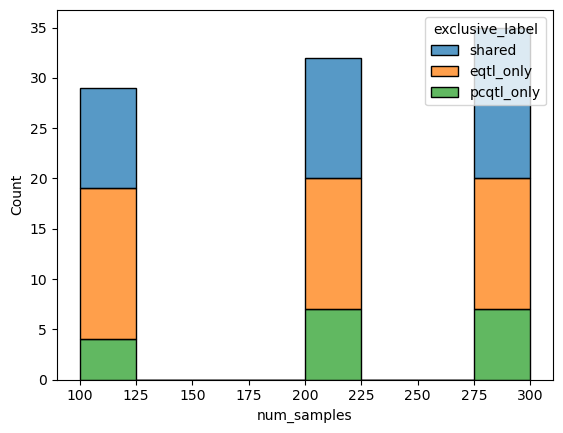

In [31]:
sns.histplot(sub_signals, x='num_samples', hue='exclusive_label', multiple='stack')

## coloc unique pcqtl signals in subsamples to eqtl signals with more samples

In [11]:
def get_lead_var_shared(sub_groups, full_groups):

    # if any share a lead variant, we assume those are the same signal and don't need to do a full coloc

    potential_lead_var_shared = pd.merge(sub_groups, full_groups, on=['cluster_id', 'tissue_id'], suffixes=['_sub', '_full'])
    potential_lead_var_shared = potential_lead_var_shared.explode('lead_var_set_full').explode('lead_var_set_sub')
    # take only the ones that share lead variants
    lead_var_shared = potential_lead_var_shared[potential_lead_var_shared['lead_var_set_full']==potential_lead_var_shared['lead_var_set_sub']]
    # drop duplicates, so only unique sub-full combinations
    lead_var_shared = lead_var_shared.drop_duplicates(['signal_id_full', 'signal_id_sub', 'cluster_id', 'tissue_id'])

    # group around sub singal sets
    lead_var_shared = lead_var_shared.groupby(['signal_id_sub', 'cluster_id', 'tissue_id']).agg({'signal_id_full':list, 
                                                                                                'num_e_coloc_sub':'first', 
                                                                                                'num_pc_coloc_sub':'first',
                                                                                                'num_e_coloc_full':'sum',
                                                                                                'num_pc_coloc_full':'sum'}).reset_index()

    print('{} small sample share a lead var with a large sample'.format(lead_var_shared['signal_id_sub'].nunique()))
    return lead_var_shared

def get_coloc_subsample(sub_config, sub_groups, full_config, full_groups, lead_var_shared):

    # get the sub credible sets that didn't have a shared lead var
    remaining_sub_groups = sub_groups[~sub_groups['signal_id'].isin(lead_var_shared['signal_id_sub'])]

    # these don't have matching lead variant annotaitons, not sure why?
    # it appears to be all the longer clusters
    # filter out larger clusters and see if any are still unmatched

    remaining_sub_groups = remaining_sub_groups[remaining_sub_groups['cluster_id'].apply(len)<150]
    print("{} of the small sample signals don't share a lead var, will need to be colocd".format(len(remaining_sub_groups)))


    # for the remaining ones, do a full coloc 
    full_groups['cs_id'] = full_groups['signal_id'].str.split('-')
    full_groups = full_groups.explode('cs_id')
    remaining_sub_groups['cs_id'] = remaining_sub_groups['signal_id'].str.split('-')
    remaining_sub_groups = remaining_sub_groups.explode('cs_id')

    groups_merged = pd.merge(remaining_sub_groups, full_groups, on=['cluster_id', 'tissue_id'], suffixes=['_sub', '_full'] )

    # add the paths for the susies
    def get_susie_path(phenotype_id, config, tissue_id):
        if len(phenotype_id) > 150:
            # Split the long QTL ID by underscores
            long_qtl_id_split = phenotype_id.split("_")
            phenotype_id = "_".join(long_qtl_id_split[-5:])
        return '{}/{}temp/{}/{}.susie.rds'.format(prefix, config['coloc_output_dir'], tissue_id, phenotype_id)

    groups_merged['susie_path_full'] = groups_merged['cs_id_full'].str.split('_cs').str[0].apply(get_susie_path, args=(full_config, my_tissue_id))
    groups_merged['susie_path_sub'] = groups_merged['cs_id_sub'].str.split('_cs').str[0].apply(get_susie_path, args=(sub_config, my_tissue_id))

    # add credible set index labels
    groups_merged['cs_num_sub'] = groups_merged['cs_id_sub'].str.split('_cs_').str[-1]
    groups_merged['cs_num_full'] = groups_merged['cs_id_full'].str.split('_cs_').str[-1]

    # # do you really need to colocalize between every pair of singals in an already coloc'd group?
    # # try with just 1 singal from each instead
    groups_merged_pruned = groups_merged.drop_duplicates(['signal_id_sub', 'signal_id_full', 'tissue_id'])
    groups_merged_pruned['pph4']=0
    print('{} colocs if we do every combination'.format(len(groups_merged)))
    print('{} colocs if we do 1 credible set per signal group'.format(len(groups_merged_pruned)))

    return groups_merged_pruned

# combine the shared lead var, coloc'd, and unique signals
def combine_signals(sub_groups, lead_var_shared, groups_merged_pruned):

    # regrouping is necessary if you don't first prune the signals 
    groups_merged_pruned = groups_merged_pruned.groupby(['signal_id_sub', 'signal_id_full', 'cluster_id', 'tissue_id']).agg({'num_e_coloc_sub':'first', 
                                                                                                    'num_pc_coloc_sub':'first',
                                                                                                    'num_e_coloc_full':'first',
                                                                                                    'num_pc_coloc_full':'first',
                                                                                                    'pph4':'max'}).reset_index()

    # take only the coloc signals
    groups_colocd = groups_merged_pruned[groups_merged_pruned['pph4'] > .75]
    print('{} subsignals had a signifigant coloc'.format(groups_colocd['signal_id_sub'].nunique()))
    groups_colocd = groups_colocd.groupby(['signal_id_sub', 'cluster_id', 'tissue_id']).agg({'num_pc_coloc_sub':'first', 
                                                                                    'num_e_coloc_sub':'first', 
                                                                                    'num_e_coloc_full':'sum',
                                                                                    'num_pc_coloc_full':'sum', 
                                                                                    'pph4':list, 
                                                                                    'signal_id_full':list}).reset_index()

    shared_signals = pd.concat([lead_var_shared, groups_colocd])

    # merge back in all the groups
    groups_no_colocd = sub_groups[~sub_groups['signal_id'].isin(shared_signals['signal_id_sub'])]
    groups_no_colocd['num_e_coloc_full'] = 0
    groups_no_colocd['num_pc_coloc_full'] = 0
    groups_no_colocd['num_e_coloc_sub'] = groups_no_colocd['num_e_coloc']
    groups_no_colocd['num_pc_coloc_sub'] = groups_no_colocd['num_pc_coloc']
    groups_no_colocd['signal_id_sub'] = groups_no_colocd['signal_id']

    print('{} signals non overlapping'.format(groups_no_colocd['signal_id'].nunique()))


    coloc_annotated_signals = pd.concat([shared_signals, groups_no_colocd[['signal_id_sub', 'num_e_coloc_full', 'num_pc_coloc_full', 'num_e_coloc_sub', 'num_pc_coloc_sub', 'cluster_id', 'tissue_id']]])
    print('{} signals had a coloc or shared lead var'.format(coloc_annotated_signals['signal_id_sub'].nunique()))

    # TODO (fix this/remove this) filter out the large clusters (an bug in the code for these)
    coloc_annotated_signals = coloc_annotated_signals[coloc_annotated_signals['cluster_id'].apply(len)<150]

    coloc_annotated_signals['exclusive_label_full'] = np.where((coloc_annotated_signals['num_e_coloc_full'] > 0), np.where((coloc_annotated_signals['num_pc_coloc_full'] > 0), 'shared', 'eqtl_only'), np.where((coloc_annotated_signals['num_pc_coloc_full'] > 0), 'pcqtl_only', 'neither'))
    coloc_annotated_signals['exclusive_label_sub'] = np.where((coloc_annotated_signals['num_e_coloc_sub'] > 0), np.where((coloc_annotated_signals['num_pc_coloc_sub'] > 0), 'shared', 'eqtl_only'), np.where((coloc_annotated_signals['num_pc_coloc_sub'] > 0), 'pcqtl_only', 'neither'))
    return coloc_annotated_signals

In [12]:
%%R -w 3 -h 5 --units in -r 200 
library(coloc)

get_coloc_from_df <- function(groups_merged_pruned){
    # Initialize values
    pph4_values <- numeric(nrow(groups_merged_pruned))
    skipped_files <- 0  # Counter for skipped files

    # Initialize progress bar
    pb <- txtProgressBar(min = 0, max = nrow(groups_merged_pruned), style = 3)

    # Loop over each row to get the PP.H4.abf value
    for (i in 1:nrow(groups_merged_pruned)) {
        tryCatch({
            susie_sub <- readRDS(file = groups_merged_pruned$susie_path_sub[i])
            susie_full <- readRDS(file = groups_merged_pruned$susie_path_full[i])
            # extract the value of PP.H4.abf that matches the credible set ids for this signal pair
            coloc_summary <- coloc.susie(susie_sub, susie_full)$summary
            matched_row <- coloc_summary[coloc_summary$idx1 == groups_merged_pruned$cs_num_sub[i] & coloc_summary$idx2 == groups_merged_pruned$cs_num_full[i], ]
            pph4_values[i] <- matched_row$PP.H4.abf[1]
        }, error = function(e) {
            # If an error occurs (e.g., file not found), assign 0 and increment the skipped file counter
            pph4_values[i] <- 0
            skipped_files <<- skipped_files + 1
            message(paste("Skipped file at index:", i, "due to error:", e$message))
        })
        
        # Update the progress bar
        setTxtProgressBar(pb, i)
    }

    # Close the progress bar
    close(pb)

    # Store the results back into the groups_merged_pruned dataframe
    groups_merged_pruned$pph4 <- pph4_values

    # Print the number of skipped files
    print(paste("Total skipped files:", skipped_files))
    return(groups_merged_pruned)
}

This is coloc version 5.2.3


### for 100 to final sample

In [32]:
# compare first sample to final sample

subsample_size_1 = 100
subsample_size_2 = final_sample_size
lead_var_shared_final= get_lead_var_shared(sub_signals[sub_signals['num_samples']==subsample_size_1], 
                                          sub_signals[sub_signals['num_samples']==subsample_size_2])
groups_merged_pruned_final = get_coloc_subsample(sub_configs[subsample_size_1], 
                                               sub_signals[sub_signals['num_samples']==subsample_size_1], 
                                               sub_configs[subsample_size_2], 
                                               sub_signals[sub_signals['num_samples']==subsample_size_2], 
                                               lead_var_shared_final)


6 small sample share a lead var with a large sample
23 of the small sample signals don't share a lead var, will need to be colocd
225 colocs if we do every combination
119 colocs if we do 1 credible set per signal group


/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_groups['cs_id'] = full_groups['signal_id'].str.split('-')
/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groups_merged_pruned['pph4']=0


In [33]:
%%R -i groups_merged_pruned_final -w 3 -h 5 --units in -r 200 -o groups_merged_pruned_final
# run coloc for the pruned set in R
groups_merged_pruned_final <- get_coloc_from_df(groups_merged_pruned_final)

  |                                                                                                                                                                                              |   0%

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "lead_var_set_sub". Fall back to string conversion. The error is: <class 'list'>
  warnings.warn('Error while trying to convert '
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "lead_var_set_full". Fall back to string conversion. The error is: <class 'list'>
  warnings.warn('Error while trying to convert '


  |==============================================================================================================================================================================================| 100%
[1] "Total skipped files: 0"


In [43]:
coloc_annotated_signals_final = combine_signals(sub_signals[sub_signals['num_samples']==subsample_size_1], lead_var_shared_final, groups_merged_pruned_final)

5 subsignals had a signifigant coloc
18 signals non overlapping
29 signals had a coloc or shared lead var


/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Text(0.5, 1.0, 'how does each small-sample signal coloc with the larger sample signals?')

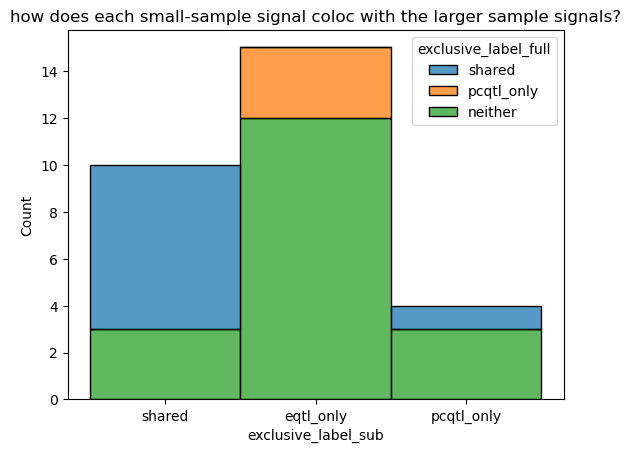

In [44]:
sns.histplot(coloc_annotated_signals_final, x='exclusive_label_sub', hue='exclusive_label_full', multiple='stack')
plt.title('how does each small-sample signal coloc with the larger sample signals?')

In [45]:
# make a flow diagram

import plotly.graph_objects as go

# Create dimensions
sub_dim = go.parcats.Dimension(
    values=coloc_annotated_signals_final.exclusive_label_sub,
    categoryorder='category ascending', label="small sample"
)

full_dim = go.parcats.Dimension(
    values=coloc_annotated_signals_final.exclusive_label_full,
    categoryorder='category ascending', label="large sample"
)

# Create parcats trace
color = coloc_annotated_signals_final.exclusive_label_sub;
colorscale = [['eqtl_only', 'lightsteelblue'], ['pcqtl_only', 'mediumseagreen'], ['shared', 'aliceblue']];

fig = go.Figure(data = [go.Parcats(dimensions=[sub_dim, full_dim],
        #line={'color': color, 'colorscale': colorscale},
        hoveron='color', hoverinfo='count+probability',
        arrangement='freeform')])

fig.show()



## for 100-200-300-full

In [37]:
# for groups in the 100 to groups in the 200
subsample_size_1 = 100
subsample_size_2 = 200
lead_var_shared_200 = get_lead_var_shared(sub_signals[sub_signals['num_samples']==subsample_size_1], sub_signals[sub_signals['num_samples']==subsample_size_2])
groups_merged_pruned_200 = get_coloc_subsample(sub_configs[subsample_size_1], sub_signals[sub_signals['num_samples']==subsample_size_1], sub_configs[subsample_size_2], sub_signals[sub_signals['num_samples']==subsample_size_2], lead_var_shared_200)

# for groups in the 100 to groups in the 300
subsample_size_2 = 300
lead_var_shared_300 = get_lead_var_shared(sub_signals[sub_signals['num_samples']==subsample_size_1], sub_signals[sub_signals['num_samples']==subsample_size_2])
groups_merged_pruned_300 = get_coloc_subsample(sub_configs[subsample_size_1], sub_signals[sub_signals['num_samples']==subsample_size_1], sub_configs[subsample_size_2], sub_signals[sub_signals['num_samples']==subsample_size_2], lead_var_shared_300)

6 small sample share a lead var with a large sample
23 of the small sample signals don't share a lead var, will need to be colocd
192 colocs if we do every combination
120 colocs if we do 1 credible set per signal group
6 small sample share a lead var with a large sample
23 of the small sample signals don't share a lead var, will need to be colocd
225 colocs if we do every combination
119 colocs if we do 1 credible set per signal group


/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [38]:
%%R -i groups_merged_pruned_200 -w 3 -h 5 --units in -r 200 -o groups_merged_pruned_200
# run coloc for the pruned set in R
groups_merged_pruned_200 <- get_coloc_from_df(groups_merged_pruned_200)

  |                                                                                                                                                                                              |   0%

  |==                                                                                                                                                                                            |   1%

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "lead_var_set_sub". Fall back to string conversion. The error is: <class 'list'>

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "lead_var_set_full". Fall back to string conversion. The error is: <class 'list'>



  |==============================================================================================================================================================================================| 100%
[1] "Total skipped files: 0"


In [39]:
%%R -i groups_merged_pruned_300 -w 3 -h 5 --units in -r 200 -o groups_merged_pruned_300
# run coloc for the pruned set in R
groups_merged_pruned_300 <- get_coloc_from_df(groups_merged_pruned_300)

  |===                                                                                                                                                                                           |   2%

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "lead_var_set_sub". Fall back to string conversion. The error is: <class 'list'>

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "lead_var_set_full". Fall back to string conversion. The error is: <class 'list'>



  |==============================================================================================================================================================================================| 100%
[1] "Total skipped files: 0"


In [40]:
# combine the shared lead var, coloc'd, and unique signals
coloc_annotated_signals_200 = combine_signals(sub_signals[sub_signals['num_samples']==100], lead_var_shared_200, groups_merged_pruned_200)
coloc_annotated_signals_300 = combine_signals(sub_signals[sub_signals['num_samples']==100], lead_var_shared_300, groups_merged_pruned_300)

5 subsignals had a signifigant coloc
18 signals non overlapping
29 signals had a coloc or shared lead var
5 subsignals had a signifigant coloc
18 signals non overlapping
29 signals had a coloc or shared lead var


/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:91: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/local/scratch/klawren/slrmtmp.46973338/ipykernel_22784/1516611404.py:93: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

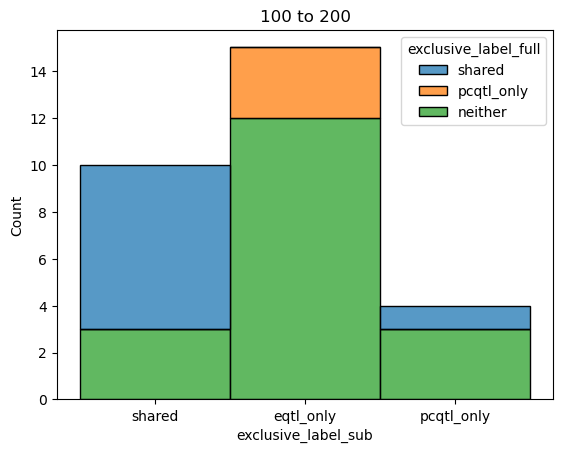

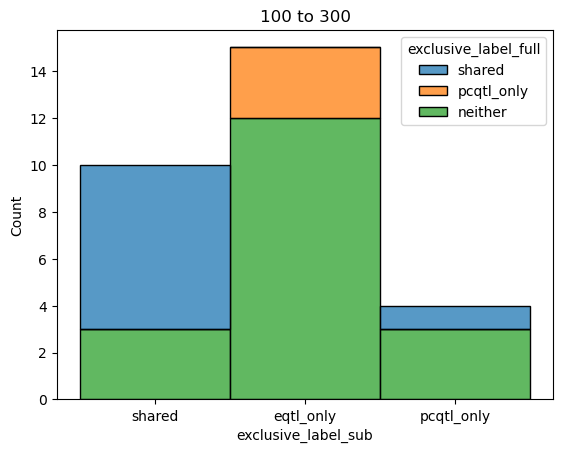

In [41]:
sns.histplot(coloc_annotated_signals_200, x='exclusive_label_sub', hue='exclusive_label_full', multiple='stack')
plt.title('100 to 200')
plt.show()
sns.histplot(coloc_annotated_signals_300, x='exclusive_label_sub', hue='exclusive_label_full', multiple='stack')
plt.title('100 to 300')
plt.show()

In [55]:
# combine all the signals
combined_annotated_signals = pd.merge(coloc_annotated_signals_200[['signal_id_sub', 'exclusive_label_full']], coloc_annotated_signals_300[['signal_id_sub', 'exclusive_label_full']], suffixes=['_200', '_300'], on='signal_id_sub')
combined_annotated_signals = pd.merge(combined_annotated_signals, coloc_annotated_signals_final[['signal_id_sub', 'exclusive_label_sub', 'exclusive_label_full']], suffixes=['', '_final'], on='signal_id_sub')
combined_annotated_signals.head()

,signal_id_sub,exclusive_label_full_200,exclusive_label_full_300,exclusive_label_sub,exclusive_label_full
0,ENSG00000087269.15_ENSG00000125388.19_e_ENSG00...,shared,shared,shared,shared
1,ENSG00000129055.12_ENSG00000182923.16_e_ENSG00...,shared,shared,shared,shared
2,ENSG00000137462.6_ENSG00000145428.14_e_ENSG000...,shared,shared,shared,shared
3,ENSG00000181061.13_ENSG00000244607.5_e_ENSG000...,pcqtl_only,pcqtl_only,eqtl_only,pcqtl_only
4,ENSG00000181061.13_ENSG00000244607.5_e_ENSG000...,pcqtl_only,pcqtl_only,eqtl_only,pcqtl_only


In [60]:
# make a flow diagram

import plotly.graph_objects as go

# Create dimensions
dim_sub = go.parcats.Dimension(
    values=combined_annotated_signals.exclusive_label_sub,
    categoryorder='category ascending', label="100 sample"
)

dim_200 = go.parcats.Dimension(
    values=combined_annotated_signals.exclusive_label_full_200,
    categoryorder='category ascending', label="200 sample"
)

dim_300 = go.parcats.Dimension(
    values=combined_annotated_signals.exclusive_label_full_300,
    categoryorder='category ascending', label="300 sample"
)

dim_full = go.parcats.Dimension(
    values=combined_annotated_signals.exclusive_label_full,
    categoryorder='category ascending', label="{} sample".format(final_sample_size)
)

# colors based on orig group
color_map = {'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}
color = [color_map[label] for label in combined_annotated_signals.exclusive_label_sub]


fig = go.Figure(data = [go.Parcats(dimensions=[dim_sub, dim_200, dim_300, dim_full],
        line={'color': color},
        hoveron='color', hoverinfo='count+probability',
        arrangement='freeform')])

fig.show()

